In [1]:
headlines = ['FDA approves gene therapy',
             'Gene therapy reduces tumor growth',
             'FDA recalls pacemakers']

In [2]:
import networkx as nx
from nltk.corpus import wordnet as wn

def graph_synsets(terms, pos=wn.NOUN, depth=2):
    """
    Create a networkx graph of the given terms to the given depth.
    """

    G = nx.Graph(
        name="WordNet Synsets Graph for {}".format(", ".join(terms)), depth=depth,
    )

    def add_term_links(G, term, current_depth):
        for syn in wn.synsets(term):
            for name in syn.lemma_names():
                G.add_edge(term, name)
                if current_depth < depth:
                    add_term_links(G, name, current_depth+1)

    for term in terms:
        add_term_links(G, term, 0)

    return G

In [3]:
G = graph_synsets(["trinket"])
print(nx.info(G))

Name: WordNet Synsets Graph for trinket
Type: Graph
Number of nodes: 25
Number of edges: 49
Average degree:   3.9200


In [4]:
nx.diameter(G)

5

In [5]:
import matplotlib.pyplot as plt

def draw_text_graph(G):
    pos = nx.spring_layout(G, scale=18)
    nx.draw_networkx_nodes(
        G, pos, node_color="white", linewidths=0, node_size=500
    )
    nx.draw_networkx_labels(G, pos, font_size=10)
    nx.draw_networkx_edges(G, pos, edge_color='lightgrey')

    plt.tick_params(
        axis='both',       # changes apply to both the x- and y-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # turn off ticks along bottom edge
        left='off',        # turn off ticks along left edge
        labelbottom='off', # turn off labels along bottom edge
        labelleft='off')   # turn off labels along left edge

    plt.show()

In [6]:
import itertools
from sklearn.base import BaseEstimator, TransformerMixin

class EntityPairs(BaseEstimator, TransformerMixin):
    def __init__(self):
        super(EntityPairs, self).__init__()

    def pairs(self, document):
        return list(itertools.permutations(set(document), 2))

    def fit(self, documents, labels=None):
        return self

    def transform(self, documents):
        return [self.pairs(document) for document in documents]

In [7]:
import networkx as nx

class GraphExtractor(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.G = nx.Graph()


    def fit(self, documents, labels=None):
        return self

    def transform(self, documents):
        for document in documents:
            for first, second in document:
                if (first, second) in self.G.edges():
                    self.G.edges[(first, second)]['weight'] += 1
                else:
                    self.G.add_edge(first, second, weight=1)
        return self.G

In [8]:
if __name__ == '__main__':
    from reader import PickledCorpusReader
    from sklearn.pipeline import Pipeline

    corpus = PickledCorpusReader('../corpus')
    docs = corpus.docs()

    graph = Pipeline([
        ('entities', EntityExtractor()),
        ('pairs', EntityPairs()),
        ('graph', GraphExtractor())
    ])

    G = graph.fit_transform(docs)
    print(nx.info(G))

OSError: No such file or directory: '/home/af/Dokumenter/Programs/AppliedTextAnalysiswithPython/corpus'

In [9]:
import heapq
from operator import itemgetter

def nbest_centrality(G, metrics, n=10):
    # Compute the centrality scores for each vertex
    nbest = {}
    for name, metric in metrics.items():
        scores = metric(G)

        # Set the score as a property on each node
        nx.set_node_attributes(G, name=name, values=scores)

        # Find the top n scores and print them along with their index
        topn = heapq.nlargest(n, scores.items(), key=itemgetter(1))
        nbest[name] = topn

    return nbest

In [10]:
from tabulate import tabulate

corpus = PickledCorpusReader('../corpus')
docs = corpus.docs()

graph = Pipeline([
        ('entities', EntityExtractor()),
        ('pairs', EntityPairs()),
        ('graph', GraphExtractor())
    ])

G = graph.fit_transform(docs)

centralities = {"Degree Centrality" : nx.degree_centrality,
                "Betweenness Centrality" : nx.betweenness_centrality}

centrality = nbest_centrality(G, centralities, 10)

for measure, scores in centrality.items():
    print("Rankings for {}:".format(measure))
    print((tabulate(scores, headers=["Top Terms", "Score"])))
    print("")

OSError: No such file or directory: '/home/af/Dokumenter/Programs/AppliedTextAnalysiswithPython/corpus'

In [11]:
H = nx.ego_graph(G, "hollywood")

NodeNotFound: Source hollywood is not in G

In [12]:
hollywood_centralities = {"closeness" : nx.closeness_centrality,
                          "eigenvector" : nx.eigenvector_centrality_numpy,
                          "katz" : nx.katz_centrality_numpy,
                          "pagerank" : nx.pagerank_numpy,}

hollywood_centrality = nbest_centrality(H, hollywood_centralities, 10)
for measure, scores in hollywood_centrality.items():
    print("Rankings for {}:".format(measure))
    print((tabulate(scores, headers=["Top Terms", "Score"])))
    print("")

NameError: name 'H' is not defined

In [13]:
H = nx.ego_graph(G, "hollywood")
edges, weights = zip(*nx.get_edge_attributes(H, "weight").items())
pos = nx.spring_layout(H, k=0.3, iterations=40)

nx.draw(
    H, pos, node_color="skyblue", node_size=20, edgelist=edges,
    edge_color=weights, width=0.25, edge_cmap=plt.cm.Pastel2,
    with_labels=True, font_size=6, alpha=0.8)
plt.show()

NodeNotFound: Source hollywood is not in G

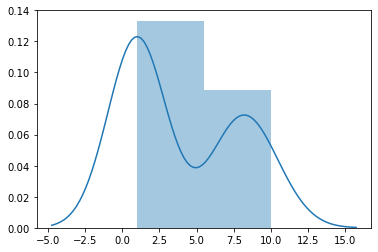

In [14]:
import seaborn as sns

sns.distplot([G.degree(v) for v in G.nodes()], norm_hist=True)
plt.show()

In [15]:
print("Baleen Entity Graph")
print("Average clustering coefficient: {}".format(nx.average_clustering(G)))
print("Transitivity: {}".format(nx.transitivity(G)))
print("Number of cliques: {}".format(nx.graph_number_of_cliques(G)))

print("Hollywood Ego Graph")
print("Average clustering coefficient: {}".format(nx.average_clustering(H)))
print("Transitivity: {}".format(nx.transitivity(H)))
print("Number of cliques: {}".format(nx.graph_number_of_cliques(H)))

Baleen Entity Graph
Average clustering coefficient: 0.25
Transitivity: 0.6104651162790697
Number of cliques: 19
Hollywood Ego Graph


NameError: name 'H' is not defined

In [16]:
import networkx as nx
from itertools import combinations

def pairwise_comparisons(G):
    """
    Produces a generator of pairs of nodes.
    """
    return combinations(G.nodes(), 2)

In [17]:
def edge_blocked_comparisons(G):
    """
    A generator of pairwise comparisons, that highlights comparisons
    between nodes that have an edge to the same entity.
    """
    for n1, n2 in pairwise_comparisons(G):
        hood1 = frozenset(G.neighbors(n1))
        hood2 = frozenset(G.neighbors(n2))
        if hood1 & hood2:
            yield n1,n2

In [18]:
from fuzzywuzzy import fuzz

def similarity(n1, n2):
    """
    Returns the mean of the partial_ratio score for each field in the two
    entities. Note that if they don't have fields that match, the score will
    be zero.
    """
    scores = [
        fuzz.partial_ratio(n1, n2),
        fuzz.partial_ratio(G.node[n1]['type'], G.node[n2]['type'])
    ]

    return float(sum(s for s in scores)) / float(len(scores))

/home/af/Dokumenter/Programs/miniconda3/envs/AppliedTextAnalysiswithPython/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [19]:
def fuzzy_blocked_comparisons(G, threshold=65):
    """
    A generator of pairwise comparisons, that highlights comparisons between
    nodes that have an edge to the same entity, but filters out comparisons
    if the similarity of n1 and n2 is below the threshold.
    """
    for n1, n2 in pairwise_comparisons(G):
        hood1 = frozenset(G.neighbors(n1))
        hood2 = frozenset(G.neighbors(n2))
        if hood1 & hood2:
            if similarity(n1, n2) > threshold:
                yield n1,n2

In [20]:
def info(G):
    """
    Wrapper for nx.info with some other helpers.
    """
    pairwise = len(list(pairwise_comparisons(G)))
    edge_blocked = len(list(edge_blocked_comparisons(G)))
    fuzz_blocked = len(list(fuzzy_blocked_comparisons(G)))

    output = [""]
    output.append("Number of Pairwise Comparisons: {}".format(pairwise))
    output.append("Number of Edge Blocked Comparisons: {}".format(edge_blocked))
    output.append("Number of Fuzzy Blocked Comparisons: {}".format(fuzz_blocked))

    return nx.info(G) + "\n".join(output)

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class FuzzyBlocker(BaseEstimator, TransformerMixin):

    def __init__(self, threshold=65):
        self.threshold = threshold

    def fit(self, G, y=None):
        return self

    def transform(self, G):
        return fuzzy_blocked_comparisons(G, self.threshold)